### A. Import relevant dependencies

In [3]:
import os
import pickle
import sys

import numpy as np
import torch
import yaml
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_undirected
from torch_geometric.utils.convert import from_networkx

try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from main.graph_formatting_utils import prepare_graph_for_gnn
from main.loss_functions import unsupervised_loss_V0, unsupervised_loss_V1
from main.node_embedding_models import GraphSAGE
from main.training_utils import train_in_cpu, train_in_gpu

### B. Check CUDA status

In [4]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("CUDA Device Count:", torch.cuda.device_count())

CUDA Available: True
GPU Name: NVIDIA L40S
CUDA Device Count: 1


### C. Load config data

In [7]:
# Load GraphSAGE config file
config_file_path = os.path.join(
    project_root, "config", "graphsage_config.yaml"
    )

with open(config_file_path, "r") as f:
    config = yaml.safe_load(f)

print(config)

input_graph_file_name = config['input_data']['graph_file_name']
input_graph_embedding_dim = config['input_data']['embedding_dim']

graphsage_channels = config['model_params']['channels']

loader_num_neighbors = config['loader_params']['num_neighbors']
loader_batch_size = config['loader_params']['batch_size']
loader_shuffle = config['loader_params']['shuffle']

training_num_epochs = config['training_params']['num_epochs']
optimizer_learning_rate = config['optimizer_params']['learning_rate']

{'model_params': {'channels': [1536, 1024, 512], 'num_layers': 2}, 'loader_params': {'num_neighbors': [50, 150], 'batch_size': 512, 'shuffle': True}, 'input_data': {'graph_file_name': 'RIZIV_hackathon_main/base_hybrid_graph.pkl', 'embedding_dim': 1536}, 'optimizer_params': {'learning_rate': 0.001}, 'training_params': {'num_epochs': 10}}


### D. Embedding model training

/home/diomedea/.pyenv/versions/3.11.6/envs/graphsage/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "
Training epochs: 100%|██████████| 10/10 [50:14<00:00, 301.46s/it, avg_loss=3.6978, mean_norm=1.1426, std_norm=0.5918]


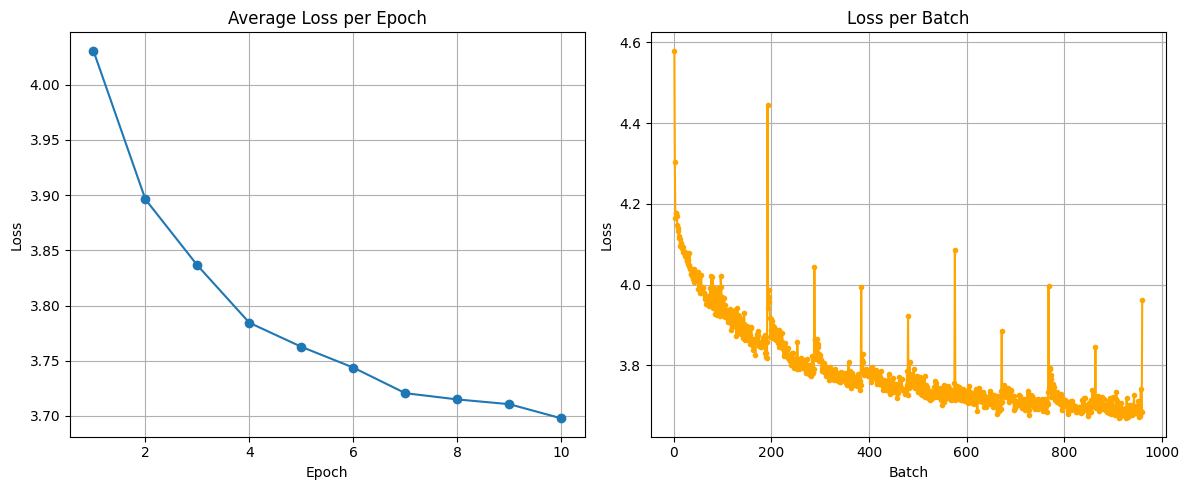

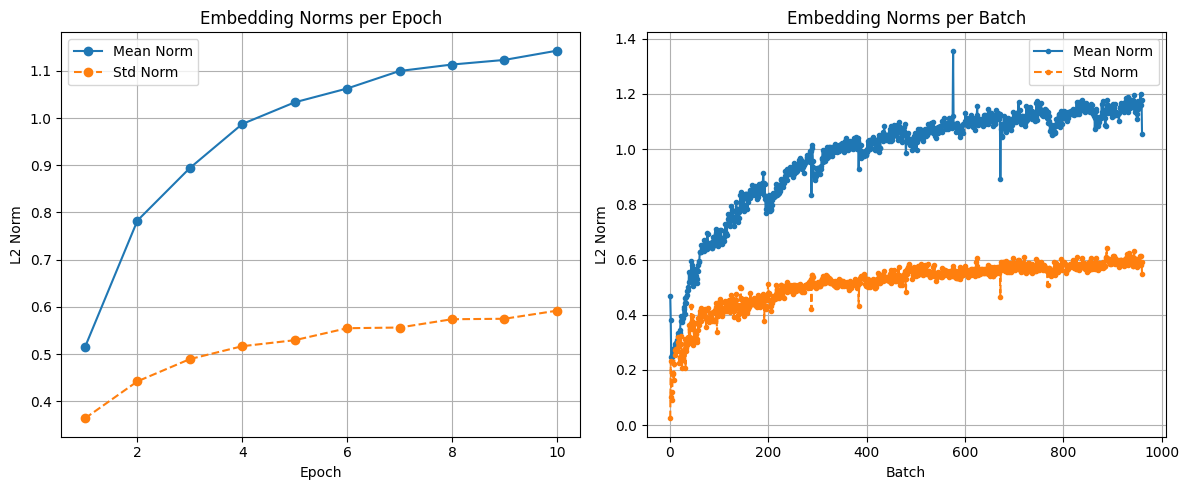

In [8]:
# Load and format graph
graph_path = os.path.join(project_root, "data", input_graph_file_name)
with open(graph_path, "rb") as f:
    G = pickle.load(f)

formatted_G, incidences = prepare_graph_for_gnn(G, embedding_dim=input_graph_embedding_dim)

# Convert the NetworkX graph to a PyTorch Geometric Data object
data = from_networkx(formatted_G)

# Ensure the graph is undirected
data.edge_index = to_undirected(data.edge_index)

# Create data attribute "x" containing the embeddings of each node complying with the PyTorch Geometric API
data.x = data.embedding
del data.embedding

# Instantiate the GraphSAGE model
model = GraphSAGE(
    channels=graphsage_channels
)

# Set device for model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Instantiate the NeighborLoader for mini-batch training
train_loader = NeighborLoader(
    data,
    num_neighbors=loader_num_neighbors,  #  neighbors for the first layer, 15 for the second
    batch_size=loader_batch_size,  # Batch size
    shuffle=loader_shuffle
)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_learning_rate)

# Define scaler if GPU is available
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

if not torch.cuda.is_available():
    train_in_cpu(model, train_loader, optimizer, num_epochs=training_num_epochs, loss_fn=unsupervised_loss_V1, debug=False, plot_eval=True)

elif torch.cuda.is_available():
    train_in_gpu(model, train_loader, optimizer, num_epochs=training_num_epochs, loss_fn=unsupervised_loss_V1, debug=False, plot_eval=True)



### F. Save embeddings and embedding model

In [ ]:
# Add Graph_SAGE embeddings to the baseline graph

## -> Move data to the same device as the model
device = next(model.parameters()).device
data_x = data.x.to(device)
data_edge_index = data.edge_index.to(device)

## -> Obtain final embeddings from the trained model
with torch.no_grad():
    final_emb = model(data_x, data_edge_index)  # shape [num_nodes, embedding_dim]
    final_emb_np = final_emb.cpu().numpy()

## -> Add them back to the cleaned_G graph
list_of_nodes = list(G.nodes())  # Must match the node ordering in data
for i, node in enumerate(list_of_nodes):
    # Store as a NumPy array (or you could store as a list if you prefer)
    G.nodes[node]["hybrid_embedding"] = final_emb_np[i]

# Define tags for the output files
training_n_hops = len(graphsage_channels)-1
channels_str = "-".join([str(i) for i in graphsage_channels])
training_num_epochs

# Define the output file names
output_graph_file_name = f"processed_graph_{training_n_hops}hop_{training_num_epochs}epochs_{channels_str}.pkl"
trained_model_file_name = f"GraphSAGE_{training_n_hops}hop_{training_num_epochs}epochs_{channels_str}.pth"

# Save the processed graph
output_graph_path = os.path.join(project_root, "data", output_graph_file_name)
with open(output_graph_path, "wb") as f:
    pickle.dump(G, f)

# Save the trained model
output_model_path = os.path.join(project_root, "data", trained_model_file_name)
torch.save(model.state_dict(), output_model_path)

In [ ]:
#def get_new_node_embedding(model, new_feature, device, self_loop=True):
#    """
#    Generate an embedding for a new node using the trained GraphSAGE model.
#    
#    Parameters:
#      model (torch.nn.Module): The trained GraphSAGE model.
#      new_feature (torch.Tensor): The new node's initial features of shape (1024,).
#      device (torch.device): The device (e.g., cuda) on which the model is located.
#      self_loop (bool, default=True): If True, adds a self-loop edge (node connected to itself).
#                                      This simulates neighbor aggregation when no neighbors exist.
#    
#    Returns:
#      torch.Tensor: The new node's embedding of shape (out_channels,).
#    """
#    # Set the model to evaluation mode.
#    model.eval()
#    
#    # Move the new node's features to the correct device.
#    new_feature = new_feature.to(device)
#    
#    if self_loop:
#        # Create a self-loop edge_index. This indicates that the node is connected to itself.
#        # The edge_index tensor must have shape [2, num_edges]; here we create a single edge (0,0).
#        edge_index = torch.tensor([[0], [0]], dtype=torch.long, device=device)
#    else:
#        # Alternatively, if you prefer no edges, you can pass an empty edge_index.
#        # Note: Without a self-loop, the model may not transform the features as intended.
#        edge_index = torch.empty((2, 0), dtype=torch.long, device=device)
#    
#    # GraphSAGE expects a batch dimension, so unsqueeze new_feature to shape [1, 1024].
#    with torch.no_grad():
#        new_embedding = model(new_feature.unsqueeze(0), edge_index)
#    
#    # Remove the batch dimension to return a tensor of shape [out_channels].
#    return new_embedding.squeeze(0)
#
## Example usage:
## Assuming 'model' is your trained GraphSAGE and you have a new node feature vector of size 1024.
#new_feature = torch.randn(1024)  # Replace with the actual feature vector for the new node.
#device = next(model.parameters()).device  # Get the device from the model.
#new_node_embedding = get_new_node_embedding(model, new_feature, device, self_loop=True)
#print("New node embedding shape:", new_node_embedding.shape)
#